https://stackoverflow.com/questions/51903350/python-vs-matlab-performance-on-algorithm

First we measure the scaling of the serial implementation

_Performance enhancement 1_: use Numba within a single array

In [1]:
!hostname

a1374aaeea07


In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

For Numpy, set how floating-point errors are handled.
    
https://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html

In [3]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# original code to be profiled optimized
The following is merely a computationally expective function

In [6]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

# profile code

In order to optimize effectively, need to understand where hot spots are


## start with function profiling
Conclusion: Most of the time is spent in "sample_entropy"

In [7]:
%prun?

Docstring:
Run a statement through the python code profiler.

Usage, in line mode:
  %prun [options] statement

Usage, in cell mode:
  %%prun [options] [statement]
  code...
  code...

In cell mode, the additional code lines are appended to the (possibly
empty) statement in the first line.  Cell mode allows you to easily
profile multiline blocks without having to put them in a separate
function.

The given statement (which doesn't require quote marks) is run via the
python profiler in a manner similar to the profile.run() function.
Namespaces are internally managed to work correctly; profile.run
cannot be used in IPython because it makes certain assumptions about
namespaces which do not hold under IPython.

Options:

-l <limit>
  you can place restrictions on what or how much of the
  profile gets printed. The limit value can be:

     * A string: only information for function names containing this string
       is printed.

     * An integer: only these many lines are printed.

     *

In [8]:
a = np.random.rand(1, 100)[0]

%prun -s tottime sample_entropy(a, 4, 0.1 * np.std(a))

         5269 function calls in 0.063 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.041    0.041    0.062    0.062 <ipython-input-6-f82a0bee80af>:2(sample_entropy)
      274    0.019    0.000    0.019    0.000 {built-in method builtins.min}
     4950    0.002    0.000    0.002    0.000 {built-in method builtins.abs}
        1    0.000    0.000    0.000    0.000 _methods.py:86(_var)
        1    0.000    0.000    0.063    0.063 {built-in method builtins.exec}
        4    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        2    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 _methods.py:133(_std)
        2    0.000    0.000    0.000    0.000 shape_base.py:63(atleast_2d)
        1    0.000    0.000    0.000    0.000 _methods.py:43(_count_reduce_items)
        1    0.000    0.000    0.000    0.000 {buil

## after determining function hot spot, use line profiling

Once we know that the majority of time is spent in "Sample entropy", investigate which lines are consuming most of the CPU time

https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/

In [7]:
!pip install line_profiler

In [8]:
%load_ext line_profiler

In [9]:
a = np.random.rand(1, 100)[0]

%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

Timer unit: 1e-06 s

Total time: 0.173882 s
File: <ipython-input-4-f82a0bee80af>
Function: sample_entropy at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def sample_entropy(time_series, sample_length, tolerance=None):
     3                                               """Calculate and return Sample Entropy of the given time series.
     4                                               Distance between two vectors defined as Euclidean distance and can
     5                                               be changed in future releases
     6                                               Args:
     7                                                   time_series: Vector or string of the sample data
     8                                                   sample_length: Number of sequential points of the time series
     9                                                   tolerance: Tolerance (default = 0.1...0.2 * s

We can see there are some lines that are taking most of the time (primarily the lines inside the loop). 

Therefore, when attempting to optimize the implementation, focus on those lines

## scaling of serial function

Before we try to make the code faster, start by measuring how the code scales as the size of the input increase

In [10]:
num_tests=3 # number of measurements for each array size
serial_original_timing_dict={}
serial_original_reslt_dict={}
for arry_size in [100,1000,2000]:#,5000,10000]:  # vary the array size
    reslt_ary=[]
    for test_indx in range(num_tests): # take multiple measurements for each array size
        a = np.random.rand(1, arry_size)[0] # create array of given size
        start_time = time.time() # start timer
        outp=sample_entropy(a, 4, 0.1 * np.std(a)) # call computationally expensive function
        elapsed_time = time.time() - start_time # how long did that take?
        serial_original_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    # store the average of the 3 runs
    serial_original_timing_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 0.11920642852783203 seconds
100 : 0.11010384559631348 seconds
100 : 0.0699310302734375 seconds
1000 : 4.037002086639404 seconds
1000 : 3.6000020503997803 seconds
1000 : 5.0666725635528564 seconds
2000 : 17.788944244384766 seconds
2000 : 23.119106769561768 seconds
2000 : 17.112669229507446 seconds


In [11]:
serial_original_timing_dict

{100: 0.09974710146586101, 1000: 4.234558900197347, 2000: 19.340240081151325}

In [12]:
# unpacking operator * -- see https://realpython.com/python-kwargs-and-args/#unpacking-with-the-asterisk-operators
# see https://realpython.com/python-zip-function/
x_orig,y_orig=zip(*serial_original_timing_dict.items())

In [13]:
x_orig # array size

(100, 1000, 2000)

In [14]:
y_orig # time in seconds

(0.09974710146586101, 4.234558900197347, 19.340240081151325)

In [15]:
z_orig = np.polyfit(x_orig, y_orig, 2) # fit data points with second order polynomial -- https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
z_orig # coefficients of the second order polynomial

array([  5.53233992e-06,  -1.49133858e-03,   1.93557560e-01])

In [16]:
f_orig = np.poly1d(z_orig) # convenience function for polynomials -- https://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html
print('f =\n',f_orig)

f =
            2
5.532e-06 x - 0.001491 x + 0.1936


In [17]:
x_orig_filled_in = np.linspace(0, 10000, 50) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html
y_orig_filled_in = f_orig(x_orig_filled_in)

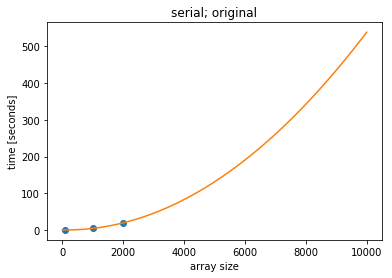

In [18]:
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; original')
plt.show()

# _optimization attempt_: replace `for` loop with `list comprehension`
    
According to line profiling, 30% of time is spent in a for loop that could be converted to a lambda function. Let's see what the performance enhancement is due to that change

In [19]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
#        for j in range(nj):                  # original
#            prev[j] = curr[j]
        prev = [curr[j] for j in range(nj)]   # list comprehension

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

In [20]:
a = np.random.rand(1, 100)[0]
%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

Timer unit: 1e-06 s

Total time: 0.142205 s
File: <ipython-input-19-b22d432b03f8>
Function: sample_entropy at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def sample_entropy(time_series, sample_length, tolerance=None):
     3                                               """Calculate and return Sample Entropy of the given time series.
     4                                               Distance between two vectors defined as Euclidean distance and can
     5                                               be changed in future releases
     6                                               Args:
     7                                                   time_series: Vector or string of the sample data
     8                                                   sample_length: Number of sequential points of the time series
     9                                                   tolerance: Tolerance (default = 0.1...0.2 * 

In [21]:
num_tests=3
serial_lambda_timing_dict={}
serial_lambda_reslt_dict={}
for arry_size in [100,1000,2000]:#,5000,10000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        outp=sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        serial_lambda_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    serial_lambda_timing_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 0.04821133613586426 seconds
100 : 0.02359175682067871 seconds
100 : 0.022885799407958984 seconds
1000 : 2.6392126083374023 seconds
1000 : 2.6565957069396973 seconds
1000 : 3.1825060844421387 seconds
2000 : 11.246560335159302 seconds
2000 : 12.602243423461914 seconds
2000 : 11.628146171569824 seconds


In [22]:
serial_lambda_timing_dict

{100: 0.03156296412150065, 1000: 2.8261047999064126, 2000: 11.825649976730347}

--> Slightly faster, but not significant

In [23]:
x_lambda,y_lambda=zip(*serial_lambda_timing_dict.items())

In [24]:
z_lambda = np.polyfit(x_lambda, y_lambda, 2)
f_lambda = np.poly1d(z_lambda)
print('f =\n',f_lambda)
x_lambda_filled_in = np.linspace(0, 10000, 50)
y_lambda_filled_in = f_lambda(x_lambda_filled_in)

f =
            2
3.102e-06 x - 0.0003076 x + 0.0313


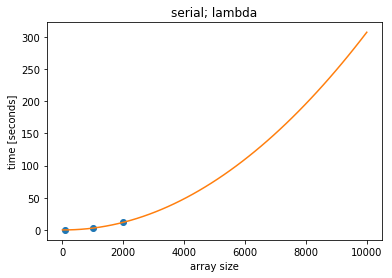

In [25]:
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; lambda')
plt.show()

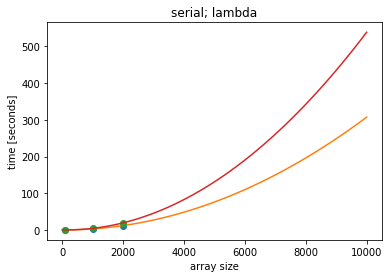

In [26]:
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; lambda')
plt.show()

_Side note; this path is not explored_:<BR>
as far as I understand, in order to use joblib, need to change the for loop to a generator:<BR>
https://joblib.readthedocs.io/en/latest/parallel.html#parallel<BR>
"The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing

## compare output of original and lambda-based

--> I don't know how to interpret the outputs, so I don't know whether the comparisons are acceptable

In [27]:
serial_original_reslt_dict

{(100, 0): array([ 2.87593107,  2.77625845,  2.14006616,  0.69314718]),
 (100, 1): array([ 2.80336038,  3.19184715,  2.48490665,         inf]),
 (100, 2): array([ 3.00181132,  2.78911802,         inf,         nan]),
 (1000, 0): array([ 2.85288505,  2.85008413,  2.84046413,  3.47609869]),
 (1000, 1): array([ 2.86156545,  2.8351453 ,  2.76661856,  2.45673577]),
 (1000, 2): array([ 2.86384387,  2.90907251,  2.85737384,  2.54272622]),
 (2000, 0): array([ 2.85407119,  2.83388266,  2.76199416,  2.68948818]),
 (2000, 1): array([ 2.86422143,  2.86014857,  2.86627421,  2.97176308]),
 (2000, 2): array([ 2.86528342,  2.87702961,  2.91394693,  2.66838494])}

In [28]:
serial_lambda_reslt_dict

{(100, 0): array([ 2.81004937,  2.74253638,  1.55814462,  0.69314718]),
 (100, 1): array([ 2.9087209 ,  3.02976202,         inf,         nan]),
 (100, 2): array([ 2.91243148,  3.50028828,  2.07944154,         inf]),
 (1000, 0): array([ 2.86419486,  2.85476851,  2.69891772,  1.99243016]),
 (1000, 1): array([ 2.86458109,  2.84921198,  2.81809361,  3.19867312]),
 (1000, 2): array([ 2.87826516,  2.87715282,  2.85115104,  3.12456515]),
 (2000, 0): array([ 2.86815026,  2.86621124,  2.8085661 ,  3.19099062]),
 (2000, 1): array([ 2.87362532,  2.85988542,  2.88666118,  3.11351531]),
 (2000, 2): array([ 2.87920176,  2.87222943,  2.89956213,  2.9077635 ])}

# optimization attempt: fine-grain concurrency: Numba
### Numba = JIT compiler that translates Python and NumPy code into machine code

https://numba.pydata.org/numba-doc/dev/user/performance-tips.html

https://numba.pydata.org/numba-doc/latest/user/parallel.html
https://numba.pydata.org/numba-doc/latest/user/jit.html#parallel-jit-option

In [29]:
import numba as nb

In [30]:
print(nb.__version__)

0.38.1


In [31]:
# https://numba.pydata.org/numba-doc/dev/reference/envvars.html#numba-envvars
import os

# If set to non-zero, printout of Numba warnings is enabled, otherwise the warnings are suppressed. The warnings can give insight into the compilation process.
os.environ["NUMBA_WARNINGS"] = "1"


I recommend playing around with the various arguments to figure out which combination is best

https://realpython.com/primer-on-python-decorators/<BR>
https://www.geeksforgeeks.org/decorators-in-python/

In [32]:
# this is the only modification to the function -- use of a decorator
@nb.jit(fastmath=True,error_model='numpy',parallel=True,nopython=True)
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) // 2

    B2=np.empty(sample_length)
    B2[0]=N
    B2[1:]=B[:sample_length - 1]
    similarity_ratio = A / B2
    se = - np.log(similarity_ratio)
    return se

In [33]:
num_tests=3
numba_reslt_dict={}
for arry_size in [100,1000,5000,10000,50000,100000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    numba_reslt_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 8.063451290130615 seconds
100 : 0.0043010711669921875 seconds
100 : 0.003926992416381836 seconds
1000 : 0.0073201656341552734 seconds
1000 : 0.006922721862792969 seconds
1000 : 0.03871631622314453 seconds
5000 : 0.06490731239318848 seconds
5000 : 0.08184003829956055 seconds
5000 : 0.09781551361083984 seconds
10000 : 0.34415173530578613 seconds
10000 : 0.5292072296142578 seconds
10000 : 0.2624332904815674 seconds
50000 : 7.044723987579346 seconds
50000 : 7.282621622085571 seconds
50000 : 7.7911217212677 seconds
100000 : 35.770923376083374 seconds
100000 : 37.7887237071991 seconds
100000 : 51.15878176689148 seconds


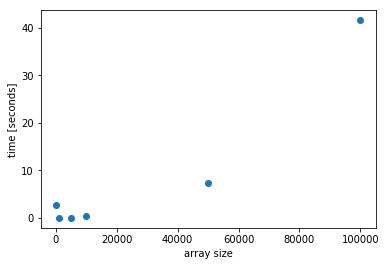

In [34]:
x_numba,y_numba=zip(*numba_reslt_dict.items())
plt.scatter(x_numba,y_numba)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.show()

In [35]:
z_numba = np.polyfit(x_numba, y_numba, 2)

In [36]:
f_numba = np.poly1d(z_numba)
print(f_numba)

          2
5.66e-09 x - 0.0001629 x + 1.285


In [37]:
x_numba_filled_in = np.linspace(0, 100000, 50)
y_numba_filled_in = f_numba(x_numba_filled_in)

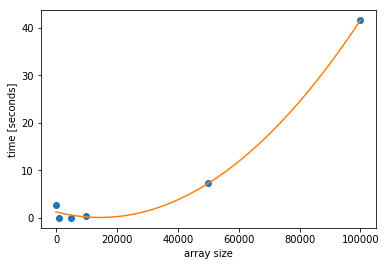

In [38]:
_=plt.plot(x_numba,y_numba,'o', x_numba_filled_in, y_numba_filled_in)
_=plt.ylabel('time [seconds]')
_=plt.xlabel('array size')

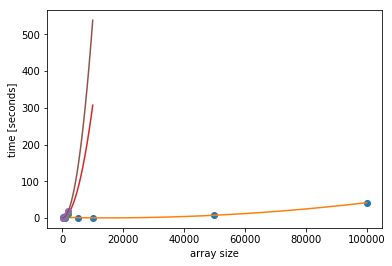

In [39]:
_=plt.plot(x_numba,y_numba,'o', x_numba_filled_in, y_numba_filled_in)
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
_=plt.ylabel('time [seconds]')
_=plt.xlabel('array size')

In [40]:
x=18000000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

677710.7990299999 seconds


677710.7990299999 seconds = 8 days

In [41]:
x=30000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

1.7377999999999998 seconds
